# Garbage Classification

Resolved **Deepeset Season 9, Quest 1:Vision** in this notebook
by *Donghyuk Kang* (donghyuk1003@gmail.com)

- [requirements](https://www.notion.so/Quest1-Vision-f2482a442e75400ba452027f2f381c1c)

- [dataset](https://www.kaggle.com/asdasdasasdas/garbage-classification)

### Table of contents

- Import Dataset
- Preprocessing
- Build CNN model
- Training the model
- Model Evaluation

### Reference

[preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers)

[data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation)

[overfit and underfit](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)



## Import Dataset

### Download dataset using kaggle cli

In [1]:
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 9.3MB/s 
     |████████████████████████████████| 4.2MB 34.5MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
     |████████████████████████████████| 143kB 52.4MB/s 
     |████████████████████████████████| 112kB 57.3MB/s 
  ERROR: Failed building wheel for lxml
    Running setup.py install for lxml ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-rclf75y8/lxml/setup.py'"'"'; __file__='"'"'/tmp/pip-install-rclf75y8/lxml/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-sozkxzwx/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.


In [2]:
import os
os.environ['KAGGLE_USERNAME'] = 'YOUR_USERNAME'
os.environ['KAGGLE_KEY'] = 'YOUR_KEY'

In [3]:
%%bash
mkdir /content/dataset
cd /content/dataset
kaggle datasets download -d asdasdasasdas/garbage-classification --unzip

100%|##########| 82.0M/82.0M [00:01<00:00, 77.1MB/s]


### Split train(validation) and test directory

In [4]:
%%bash
mkdir /content/dataset/garbage\ classification/Garbage\ classification/train
mv /content/dataset/garbage\ classification/Garbage\ classification/cardboard /content/dataset/garbage\ classification/Garbage\ classification/train
mv /content/dataset/garbage\ classification/Garbage\ classification/glass /content/dataset/garbage\ classification/Garbage\ classification/train
mv /content/dataset/garbage\ classification/Garbage\ classification/metal /content/dataset/garbage\ classification/Garbage\ classification/train
mv /content/dataset/garbage\ classification/Garbage\ classification/paper /content/dataset/garbage\ classification/Garbage\ classification/train
mv /content/dataset/garbage\ classification/Garbage\ classification/plastic /content/dataset/garbage\ classification/Garbage\ classification/train
mv /content/dataset/garbage\ classification/Garbage\ classification/trash /content/dataset/garbage\ classification/Garbage\ classification/train

In [5]:
%%bash
mkdir /content/dataset/garbage\ classification/Garbage\ classification/test
mkdir /content/dataset/garbage\ classification/Garbage\ classification/test/cardboard
mkdir /content/dataset/garbage\ classification/Garbage\ classification/test/glass
mkdir /content/dataset/garbage\ classification/Garbage\ classification/test/metal
mkdir /content/dataset/garbage\ classification/Garbage\ classification/test/paper
mkdir /content/dataset/garbage\ classification/Garbage\ classification/test/plastic
mkdir /content/dataset/garbage\ classification/Garbage\ classification/test/trash
mv /content/dataset/garbage\ classification/Garbage\ classification/train/cardboard/*0.jpg /content/dataset/garbage\ classification/Garbage\ classification/test/cardboard
mv /content/dataset/garbage\ classification/Garbage\ classification/train/glass/*0.jpg /content/dataset/garbage\ classification/Garbage\ classification/test/glass
mv /content/dataset/garbage\ classification/Garbage\ classification/train/metal/*0.jpg /content/dataset/garbage\ classification/Garbage\ classification/test/metal
mv /content/dataset/garbage\ classification/Garbage\ classification/train/paper/*0.jpg /content/dataset/garbage\ classification/Garbage\ classification/test/paper
mv /content/dataset/garbage\ classification/Garbage\ classification/train/plastic/*0.jpg /content/dataset/garbage\ classification/Garbage\ classification/test/plastic
mv /content/dataset/garbage\ classification/Garbage\ classification/train/trash/*0.jpg /content/dataset/garbage\ classification/Garbage\ classification/test/trash

### Load dataset

In [6]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

train_path = './dataset/garbage classification/Garbage classification/train'
test_path = './dataset/garbage classification/Garbage classification/test'

In [7]:
img_list = glob.glob(os.path.join('./dataset/garbage classification/Garbage classification', '*/*/*.jpg'))
print(len(img_list))

2527


In [8]:
num_classes = 6
batch_size = 32
img_height = 224
img_width = 224

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="training",
  labels='inferred',
  label_mode='categorical',
  seed=22,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2276 files belonging to 6 classes.
Using 1821 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="validation",
  labels='inferred',
  label_mode='categorical',
  seed=22,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2276 files belonging to 6 classes.
Using 455 files for validation.


In [11]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_path,
  labels='inferred',
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 251 files belonging to 6 classes.


In [12]:
print(train_ds.class_names)
print(test_ds.class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## Preprocessing

### Data augmentation

1. Random invert

reference: https://www.tensorflow.org/tutorials/images/data_augmentation

In [13]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

def random_invert(factor=0.5):
  return tf.keras.layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

In [14]:
class RandomInvert(tf.keras.layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

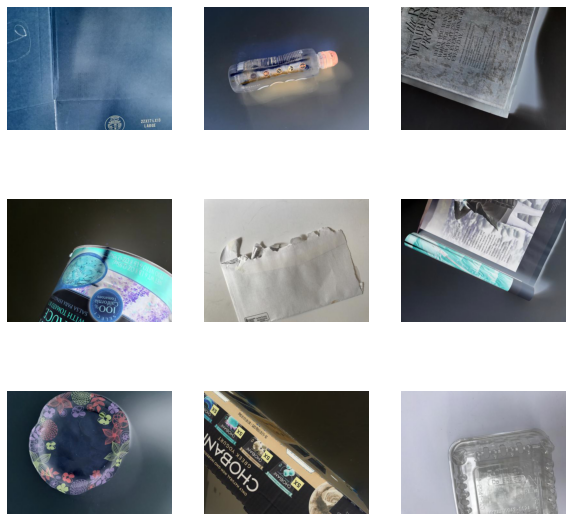

In [15]:
import random

plt.figure(figsize=(10,10))
for i, img_path in enumerate(random.sample(img_list, 9)):
  img = tf.keras.preprocessing.image.load_img(img_path)
  img = tf.keras.preprocessing.image.img_to_array(img, dtype=np.uint8)
  
  plt.subplot(3, 3, i+1)
  plt.imshow(RandomInvert()(img))
  plt.axis('off')

2. Cutmix

code from [cutmix-and-mixup-on-gpu-tpu](https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu)

have changed some variables according to this project(`CLASSES`, `IMAGE_SIZE`, `AUG_BATCH` etc)

In [16]:
def onehot(image,label):
    CLASSES = num_classes
    return image,tf.one_hot(label,CLASSES)

def cutmix(image, label, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    DIM = img_width
    CLASSES = num_classes
    
    imgs = []; labs = []
    for j in range(batch_size):
        # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        # CHOOSE RANDOM IMAGE TO CUTMIX WITH
        k = tf.cast( tf.random.uniform([],0,batch_size),tf.int32)
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # MAKE CUTMIX IMAGE
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        # MAKE CUTMIX LABEL
        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(batch_size,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(batch_size,CLASSES))
    return image2,label2

3. Mixup 

code from [cutmix-and-mixup-on-gpu-tpu](https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu)

have changed some variables according to this project(`CLASSES`, `IMAGE_SIZE`, `AUG_BATCH` etc)

In [17]:
def mixup(image, label, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with mixup applied
    DIM = img_width
    CLASSES = num_classes
    
    imgs = []; labs = []
    for j in range(batch_size):
        # DO MIXUP WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.float32)
        # CHOOSE RANDOM
        k = tf.cast( tf.random.uniform([],0,batch_size),tf.int32)
        a = tf.random.uniform([],0,1)*P # this is beta dist with alpha=1.0
        # MAKE MIXUP IMAGE
        img1 = image[j,]
        img2 = image[k,]
        imgs.append((1-a)*img1 + a*img2)
        # MAKE CUTMIX LABEL
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(batch_size,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(batch_size,CLASSES))
    return image2,label2

In [18]:
def transform(image,label):
    # THIS FUNCTION APPLIES BOTH CUTMIX AND MIXUP
    DIM = img_width
    CLASSES = num_classes
    SWITCH = 0.5
    CUTMIX_PROB = 0.666
    MIXUP_PROB = 0.666
    # FOR SWITCH PERCENT OF TIME WE DO CUTMIX AND (1-SWITCH) WE DO MIXUP
    image2, label2 = cutmix(image, label, CUTMIX_PROB)
    image3, label3 = mixup(image, label, MIXUP_PROB)
    imgs = []; labs = []
    for j in range(batch_size):
        P = tf.cast( tf.random.uniform([],0,1)<=SWITCH, tf.float32)
        imgs.append(P*image2[j,]+(1-P)*image3[j,])
        labs.append(P*label2[j,]+(1-P)*label3[j,])
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image4 = tf.reshape(tf.stack(imgs),(batch_size,DIM,DIM,3))
    label4 = tf.reshape(tf.stack(labs),(batch_size,CLASSES))
    return image4,label4

Check if `transform()` works properly with visualization

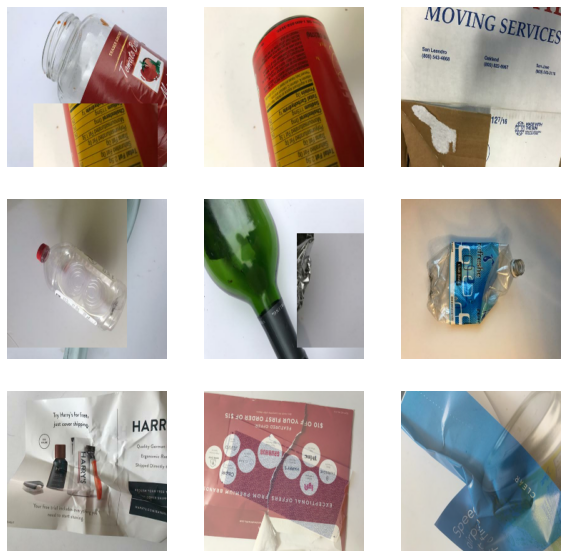

In [19]:
row = 3; col = 3;
all_elements = test_ds.unbatch()
augmented_element = all_elements.repeat().batch(batch_size).map(transform)

for (img,label) in augmented_element:
    plt.figure(figsize=(10,int(10*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(tf.keras.preprocessing.image.img_to_array(img[j,], dtype=np.uint8))
    plt.show()
    break

## Get batches

applied `transform()` on the dataset rather than on model as layer.

In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_batches = train_ds.map(transform).unbatch().cache().shuffle(1000).repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
validation_batches = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 224, 224, 3]), TensorShape([32, 6]))

## Build CNN model

### Default data augmentation

Methods from keras preprocessing, such as `RandomFlip()`, `RandomRotation()`, `RandomZoom()`, `RandomTranslation()`, `RandomContrast()` have been used for default data augmentation

In [22]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
        tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
    ]
)

Constructed the model with Convoultional Layer, Pooling Layer and Dense Layer

In [23]:
model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_width, img_height, 3)),
  data_augmentation,

  tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=2),
  
  tf.keras.layers.Conv2D(filters=64, kernel_size=1, activation='relu'),
  tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=2),

  tf.keras.layers.Conv2D(filters=128, kernel_size=1, activation='relu'),
  tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=2),

  tf.keras.layers.Conv2D(filters=128, kernel_size=1, activation='relu'),
  tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=2),

  tf.keras.layers.Conv2D(filters=32, kernel_size=1, activation='relu'),
  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      4160      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)      

In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

## Training the model

In [27]:
history = model.fit(train_batches,
                    epochs=400,
                    steps_per_epoch=1821//batch_size,
                    validation_data=validation_batches)

Epoch 1/400
56/56 [==============================] - 8s 149ms/step - loss: 1.7362 - acc: 0.2405 - val_loss: 1.7258 - val_acc: 0.2330
Epoch 2/400
56/56 [==============================] - 7s 124ms/step - loss: 1.7333 - acc: 0.2310 - val_loss: 1.7233 - val_acc: 0.2330
Epoch 3/400
56/56 [==============================] - 7s 124ms/step - loss: 1.7282 - acc: 0.2394 - val_loss: 1.6413 - val_acc: 0.2989
Epoch 4/400
56/56 [==============================] - 7s 125ms/step - loss: 1.6354 - acc: 0.3086 - val_loss: 1.5782 - val_acc: 0.3055
Epoch 5/400
56/56 [==============================] - 7s 125ms/step - loss: 1.5892 - acc: 0.3421 - val_loss: 1.5180 - val_acc: 0.3253
Epoch 6/400
56/56 [==============================] - 7s 125ms/step - loss: 1.5882 - acc: 0.3527 - val_loss: 1.6170 - val_acc: 0.2989
Epoch 7/400
56/56 [==============================] - 7s 125ms/step - loss: 1.5697 - acc: 0.3583 - val_loss: 1.4709 - val_acc: 0.3692
Epoch 8/400
56/56 [==============================] - 7s 126ms/step - 

Get the graph of accuracy and loss through epochs

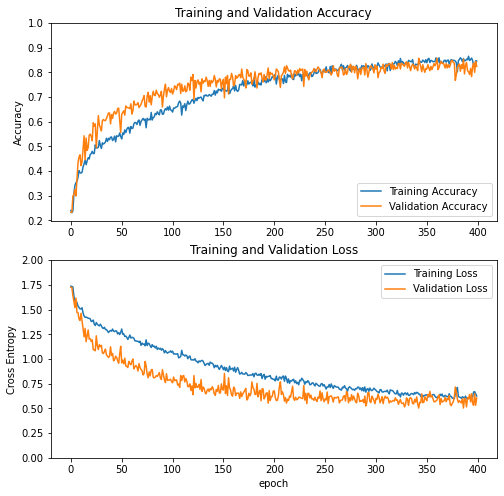

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Model evaluation

In [29]:
model.evaluate(test_ds)

8/8 [==============================] - 2s 216ms/step - loss: 0.6191 - acc: 0.7888


[0.6190813183784485, 0.788844645023346]

In [92]:
tf.keras.backend.clear_session()